# Installing pyspark and dependancies


In [2]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq


openjdk-8-jdk-headless is already the newest version (8u252-b09-1~18.04).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 33 not upgraded.


In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"


# Importing packages and libraries

In [1]:
#Pyspark libraries:
import pyspark
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.sql.functions import isnan, when, count, col



#For Data representation and visualisation:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 60)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import LabelBinarizer

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Creating spark sesssion

In [2]:
conf = SparkConf().set("spark.ui.port", "4050").set('spark.executor.memory', '4G').set('spark.driver.memory', '45G').set('spark.driver.maxResultSize', '10G')

sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.appName('Forest_Covertype').getOrCreate()

# Create ngrok tunnel to check the Spark UI

In [5]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
get_ipython().system_raw('./ngrok http 4050 &')
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

--2020-07-10 19:04:38--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 34.225.3.211, 34.192.84.136, 3.212.117.40, ...
Connecting to bin.equinox.io (bin.equinox.io)|34.225.3.211|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  44.2MB/s    in 0.3s    

2020-07-10 19:04:39 (44.2 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
https://25467b5db80e.ngrok.io


# Checking if everything is ok 

In [6]:

spark

In [ ]:
sc._conf.getAll()

[('spark.driver.memory', '45G'),
 ('spark.executor.id', 'driver'),
 ('spark.app.id', 'local-1594342296449'),
 ('spark.driver.maxResultSize', '10G'),
 ('spark.app.name', 'pyspark-shell'),
 ('spark.driver.port', '44311'),
 ('spark.ui.port', '4050'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.submit.pyFiles', ''),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.host', '2934e981ded8'),
 ('spark.executor.memory', '4G'),
 ('spark.ui.showConsoleProgress', 'true')]

# Linking colab to google drive 

In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Reading Dataset

In [3]:
dataset = '/content/gdrive/My Drive/Datasets/covtype.csv'
data = spark.read.csv(dataset,header = True, inferSchema = True)


# Data exploration

In [9]:
# Displaying the dataset:
data.show(5)

+---------+------+-----+--------------------------------+------------------------------+-------------------------------+-------------+--------------+-------------+----------------------------------+----------------+----------------+----------------+----------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+----------+
|Elevation|Aspect|Slope|Horizontal_Distance_To_Hydrology|Vertical_Distance_To_Hydrology|Horizontal_Distance_To_Roadways|Hillshade_9am|Hillshade_Noon|Hillshade_3pm|Horizontal_Distance_To_Fire_Points|Wilderness_Area1|Wilderness_Area2|Wilderness_Area3|Wi

In [10]:
# Listing the columns of dataset:
data.printSchema()

root
 |-- Elevation: integer (nullable = true)
 |-- Aspect: integer (nullable = true)
 |-- Slope: integer (nullable = true)
 |-- Horizontal_Distance_To_Hydrology: integer (nullable = true)
 |-- Vertical_Distance_To_Hydrology: integer (nullable = true)
 |-- Horizontal_Distance_To_Roadways: integer (nullable = true)
 |-- Hillshade_9am: integer (nullable = true)
 |-- Hillshade_Noon: integer (nullable = true)
 |-- Hillshade_3pm: integer (nullable = true)
 |-- Horizontal_Distance_To_Fire_Points: integer (nullable = true)
 |-- Wilderness_Area1: integer (nullable = true)
 |-- Wilderness_Area2: integer (nullable = true)
 |-- Wilderness_Area3: integer (nullable = true)
 |-- Wilderness_Area4: integer (nullable = true)
 |-- Soil_Type1: integer (nullable = true)
 |-- Soil_Type2: integer (nullable = true)
 |-- Soil_Type3: integer (nullable = true)
 |-- Soil_Type4: integer (nullable = true)
 |-- Soil_Type5: integer (nullable = true)
 |-- Soil_Type6: integer (nullable = true)
 |-- Soil_Type7: integer

In [11]:
# we are converting pyspark dataframe to pandas, for data exploration and analysis.
data_pd = data.toPandas() 

In [12]:
# Displaying the statistics of the dataset:
data_pd.describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
count,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000
mean,2959.365301,155.656807,14.103704,269.428217,46.418855,2350.146611,212.146049,223.318716,142.528263,1980.291226,0.448865,0.051434,0.436074,0.063627,0.005217,0.012952,0.008301,0.021335,0.002749,0.011316,0.000181,0.000308,0.001974,0.056168,0.021359,0.051584,0.030001,0.001031,0.000005,0.004897,0.005890,0.003268,0.006921,0.015936,0.001442,0.057439,0.099399,0.036622,0.000816,0.004456,0.001869,0.001628,0.198356,0.051927,0.044175,0.090392,0.077716,0.002773,0.003255,0.000205,0.000513,0.026803,0.023762,0.015060,2.051471
std,279.984734,111.913721,7.488242,212.549356,58.295232,1559.254870,26.769889,19.768697,38.274529,1324.195210,0.497379,0.220882,0.495897,0.244087,0.072039,0.113066,0.090731,0.144499,0.052356,0.105775,0.013442,0.017550,0.044387,0.230245,0.144579,0.221186,0.170590,0.032092,0.002272,0.069804,0.076518,0.057077,0.082902,0.125228,0.037950,0.232681,0.299197,0.187833,0.028551,0.066605,0.043193,0.040318,0.398762,0.221879,0.205483,0.286743,0.267725,0.052584,0.056957,0.014310,0.022641,0.161508,0.152307,0.121791,1.396504
min,1859.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2809.000000,58.000000,9.000000,108.000000,7.000000,1106.000000,198.000000,213.000000,119.000000,1024.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,2996.000000,127.000000,13.000000,218.000000,30.000000,1997.000000,218.000000,226.000000,143.000000,1710.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000

In [13]:
# Printing the shape of dataset:
print((data.count(), len(data.columns)))

(581012, 55)


# Outlier detection and removal

Focusing on outliers, defined by Gladwell as people who do not fit into our normal understanding of achievement. An outlier is a data point that is distant from other similar points. They may be due to variability in the measurement or may indicate experimental errors. If possible, outliers should be excluded from the data set.



In [14]:
# Fucntion to check outliers range:
def outlier_detection(df):
    
    limits = {
        x: dict(
            zip(["q1", "q3"], df.approxQuantile(x, [0.25, 0.75], 0))
        )
        for x,y in zip(df.columns, df.dtypes) if y[1] == "int"
    }

    for x in limits:
        iqr = limits[x]['q3'] - limits[x]['q1']
        limits[x]['min'] = limits[x]['q1'] - (iqr * 1.5)
        limits[x]['max'] = limits[x]['q3'] + (iqr * 1.5)

    return limits

In [15]:
# Getting the range/limit of each dataset column:
outlier_detection(data)

{'Aspect': {'max': 563.0, 'min': -245.0, 'q1': 58.0, 'q3': 260.0},
 'Cover_Type': {'max': 3.5, 'min': -0.5, 'q1': 1.0, 'q3': 2.0},
 'Elevation': {'max': 3694.0, 'min': 2278.0, 'q1': 2809.0, 'q3': 3163.0},
 'Hillshade_3pm': {'max': 241.5, 'min': 45.5, 'q1': 119.0, 'q3': 168.0},
 'Hillshade_9am': {'max': 280.5, 'min': 148.5, 'q1': 198.0, 'q3': 231.0},
 'Hillshade_Noon': {'max': 273.0, 'min': 177.0, 'q1': 213.0, 'q3': 237.0},
 'Horizontal_Distance_To_Fire_Points': {'max': 4839.0,
  'min': -1265.0,
  'q1': 1024.0,
  'q3': 2550.0},
 'Horizontal_Distance_To_Hydrology': {'max': 798.0,
  'min': -306.0,
  'q1': 108.0,
  'q3': 384.0},
 'Horizontal_Distance_To_Roadways': {'max': 6661.0,
  'min': -2227.0,
  'q1': 1106.0,
  'q3': 3328.0},
 'Slope': {'max': 31.5, 'min': -4.5, 'q1': 9.0, 'q3': 18.0},
 'Soil_Type1': {'max': 0.0, 'min': 0.0, 'q1': 0.0, 'q3': 0.0},
 'Soil_Type10': {'max': 0.0, 'min': 0.0, 'q1': 0.0, 'q3': 0.0},
 'Soil_Type11': {'max': 0.0, 'min': 0.0, 'q1': 0.0, 'q3': 0.0},
 'Soil_Type1

Boxplot : 
A boxplot is a standardized way of displaying the distribution of data based on a five number summary (“minimum”, first quartile (Q1), median, third quartile (Q3), and “maximum”). It can also tell if the data is symmetrical, how tightly the data is grouped, and if and how the data is skewed.

For data representation, pandas is used as pyspark doesn't support it. 

Boxplot is done for numerical featurers here.

iqr: 354.0
fence_low: 2278.0
fence_high 3694.0


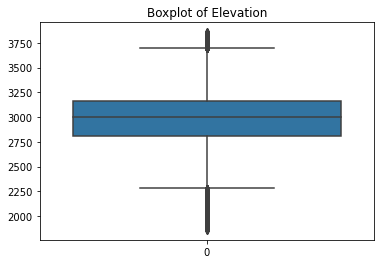

In [16]:
# Boxplot of elevation
sns.boxplot(data=data_pd["Elevation"]).set_title('Boxplot of Elevation')
q1 = pd.DataFrame(data_pd["Elevation"]).quantile(0.25)[0]
q3 = pd.DataFrame(data_pd["Elevation"]).quantile(0.75)[0]
iqr = q3 - q1 #Interquartile range

fence_low = q1 - (1.5*iqr)
fence_high = q3 + (1.5*iqr)

print("iqr:" ,iqr)
print("fence_low:" ,fence_low)
print("fence_high" ,fence_high)

iqr: 202.0
fence_low: -245.0
fence_high 563.0


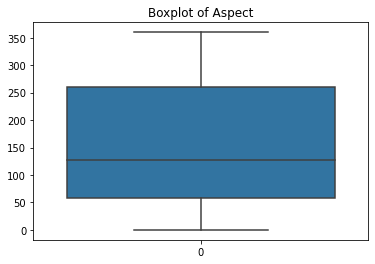

In [17]:
# Boxplot of Aspect
sns.boxplot(data=data_pd["Aspect"]).set_title('Boxplot of Aspect')

q1 = pd.DataFrame(data_pd["Aspect"]).quantile(0.25)[0]
q3 = pd.DataFrame(data_pd["Aspect"]).quantile(0.75)[0]
iqr = q3 - q1 #Interquartile range

fence_low = q1 - (1.5*iqr)
fence_high = q3 + (1.5*iqr)

print("iqr:" ,iqr)
print("fence_low:" ,fence_low)
print("fence_high" ,fence_high)

iqr: 9.0
fence_low: -4.5
fence_high 31.5


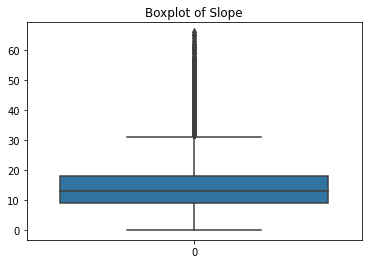

In [18]:
# Boxplot of Slope
sns.boxplot(data=data_pd["Slope"]).set_title('Boxplot of Slope')


q1 = pd.DataFrame(data_pd["Slope"]).quantile(0.25)[0]
q3 = pd.DataFrame(data_pd["Slope"]).quantile(0.75)[0]
iqr = q3 - q1 #Interquartile range

fence_low = q1 - (1.5*iqr)
fence_high = q3 + (1.5*iqr)

print("iqr:" ,iqr)
print("fence_low:" ,fence_low)
print("fence_high" ,fence_high)

iqr: 276.0
fence_low: -306.0
fence_high 798.0


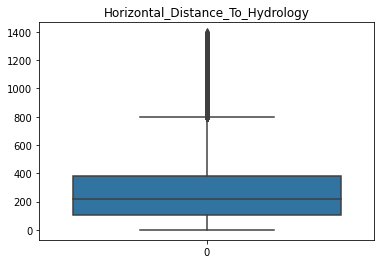

In [19]:
# Boxplot of Horizontal_Distance_To_Hydrology
sns.boxplot(data=data_pd["Horizontal_Distance_To_Hydrology"]).set_title('Horizontal_Distance_To_Hydrology')


q1 = pd.DataFrame(data_pd["Horizontal_Distance_To_Hydrology"]).quantile(0.25)[0]
q3 = pd.DataFrame(data_pd["Horizontal_Distance_To_Hydrology"]).quantile(0.75)[0]
iqr = q3 - q1 #Interquartile range

fence_low = q1 - (1.5*iqr)
fence_high = q3 + (1.5*iqr)

print("iqr:" ,iqr)
print("fence_low:" ,fence_low)
print("fence_high" ,fence_high)

iqr: 62.0
fence_low: -86.0
fence_high 162.0


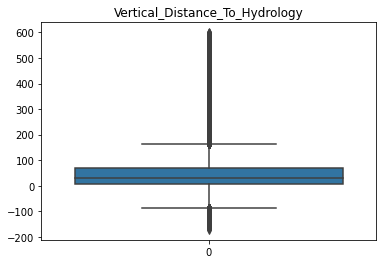

In [20]:
# Boxplot of Vertical_Distance_To_Hydrology
sns.boxplot(data=data_pd["Vertical_Distance_To_Hydrology"]).set_title('Vertical_Distance_To_Hydrology')

q1 = pd.DataFrame(data_pd["Vertical_Distance_To_Hydrology"]).quantile(0.25)[0]
q3 = pd.DataFrame(data_pd["Vertical_Distance_To_Hydrology"]).quantile(0.75)[0]
iqr = q3 - q1 #Interquartile range

fence_low = q1 - (1.5*iqr)
fence_high = q3 + (1.5*iqr)

print("iqr:" ,iqr)
print("fence_low:" ,fence_low)
print("fence_high" ,fence_high)

iqr: 2222.0
fence_low: -2227.0
fence_high 6661.0


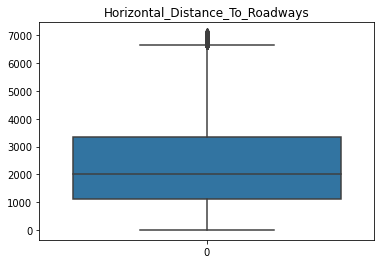

In [21]:
# Boxplot of Horizontal_Distance_To_Roadways
sns.boxplot(data=data_pd["Horizontal_Distance_To_Roadways"]).set_title('Horizontal_Distance_To_Roadways')

q1 = pd.DataFrame(data_pd["Horizontal_Distance_To_Roadways"]).quantile(0.25)[0]
q3 = pd.DataFrame(data_pd["Horizontal_Distance_To_Roadways"]).quantile(0.75)[0]
iqr = q3 - q1 #Interquartile range

fence_low = q1 - (1.5*iqr)
fence_high = q3 + (1.5*iqr)

print("iqr:" ,iqr)
print("fence_low:" ,fence_low)
print("fence_high" ,fence_high)

iqr: 33.0
fence_low: 148.5
fence_high 280.5


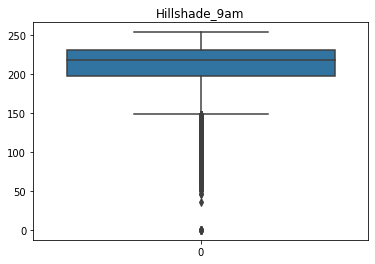

In [22]:
# Boxplot of Hillshade_9am
sns.boxplot(data=data_pd["Hillshade_9am"]).set_title('Hillshade_9am')

q1 = pd.DataFrame(data_pd["Hillshade_9am"]).quantile(0.25)[0]
q3 = pd.DataFrame(data_pd["Hillshade_9am"]).quantile(0.75)[0]
iqr = q3 - q1 #Interquartile range

fence_low = q1 - (1.5*iqr)
fence_high = q3 + (1.5*iqr)

print("iqr:" ,iqr)
print("fence_low:" ,fence_low)
print("fence_high" ,fence_high)

iqr: 24.0
fence_low: 177.0
fence_high 273.0


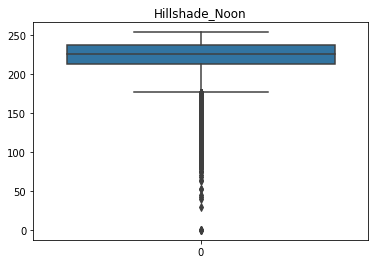

In [23]:
# Boxplot of Hillshade_Noon
sns.boxplot(data=data_pd["Hillshade_Noon"]).set_title('Hillshade_Noon')

q1 = pd.DataFrame(data_pd["Hillshade_Noon"]).quantile(0.25)[0]
q3 = pd.DataFrame(data_pd["Hillshade_Noon"]).quantile(0.75)[0]
iqr = q3 - q1 #Interquartile range

fence_low = q1 - (1.5*iqr)
fence_high = q3 + (1.5*iqr)

print("iqr:" ,iqr)
print("fence_low:" ,fence_low)
print("fence_high" ,fence_high)

iqr: 49.0
fence_low: 45.5
fence_high 241.5


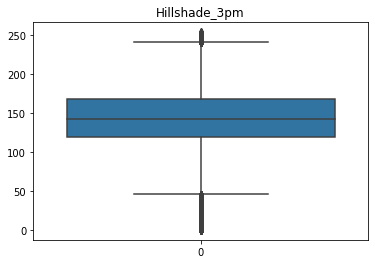

In [24]:
# Boxplot of Hillshade_3pm
sns.boxplot(data=data_pd["Hillshade_3pm"]).set_title('Hillshade_3pm')

q1 = pd.DataFrame(data_pd["Hillshade_3pm"]).quantile(0.25)[0]
q3 = pd.DataFrame(data_pd["Hillshade_3pm"]).quantile(0.75)[0]
iqr = q3 - q1 #Interquartile range

fence_low = q1 - (1.5*iqr)
fence_high = q3 + (1.5*iqr)

print("iqr:" ,iqr)
print("fence_low:" ,fence_low)
print("fence_high" ,fence_high)

iqr: 1526.0
fence_low: -1265.0
fence_high


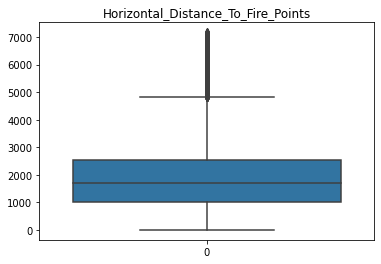

In [25]:
# Boxplot of Horizontal_Distance_To_Fire_Points
sns.boxplot(data=data_pd["Horizontal_Distance_To_Fire_Points"]).set_title('Horizontal_Distance_To_Fire_Points')

q1 = pd.DataFrame(data_pd["Horizontal_Distance_To_Fire_Points"]).quantile(0.25)[0]
q3 = pd.DataFrame(data_pd["Horizontal_Distance_To_Fire_Points"]).quantile(0.75)[0]
iqr = q3 - q1 #Interquartile range

fence_low = q1 - (1.5*iqr)
fence_high = q3 + (1.5*iqr)

print("iqr:" ,iqr)
print("fence_low:" ,fence_low)
print("fence_high")

Detected feature with more outliers:

1. Horizontal_Distance_To_Fire_Points
2. Horizontal_Distance_To_Roadways \

Quantile  : It is where a sample is divided into equal-sized, adjacent, subgroups (that's why it's sometimes called a “fractile“). It can also refer to dividing a probability distribution into areas of equal probability. Quartiles are also quantiles; they divide the distribution into four equal parts.

ApproxQuantile : Calculates the approximate quantiles of a numerical column of a DataFrame.



Outlier removal in Horizontal distance to firepoints :

In [4]:
# Calculating quantileprobs :
quantitleProbs = [0.25, 0.75]
relError = 0.0
final = data.approxQuantile('Horizontal_Distance_To_Fire_Points',quantitleProbs,relError)
print("final limit:",final )

final limit: [1024.0, 2550.0]


In [5]:
# Calculating IQR , fence_high and fence_low :
iqr = 2550.0 - 1024.0 #Interquartile range

fence_low = 1024.0 - (1.5*iqr)
fence_high = 2550.0 + (1.5*iqr)
print ("fence_low:" , fence_low)
print("fence_high:" , fence_high)

fence_low: -1265.0
fence_high: 4839.0


In [6]:
# outlier removal with respect to Horizontal_Distance_To_Fire_Points :
outlier1 = data.filter((col("Horizontal_Distance_To_Fire_Points") > fence_low) & (col("Horizontal_Distance_To_Fire_Points") < fence_high))

Outlier removal in Horizontal_Distance_To_Roadways :

In [7]:
# Calculating quantileprobs :
quantitleProbs = [0.25, 0.75]
relError = 0.0
final1 = data.approxQuantile('Horizontal_Distance_To_Roadways',quantitleProbs,relError)
print("final_1 :",final1)

final_1 : [1106.0, 3328.0]


In [8]:
# Calculating IQR, fence_high and fence_low :
iqr1 = 3328.0 - 1106.0 #Interquartile

fence_low1 = 1106.0 - (1.5*iqr)
fence_high1 = 3328.0 + (1.5*iqr)
print ("fence_low:" , fence_low1)
print("fence_high:" , fence_high1)

fence_low: -1183.0
fence_high: 5617.0


In [9]:
# outlier removal with respect to Horizontal_Distance_To_Roadways :
data_withoutoutliers = outlier1.filter((col("Horizontal_Distance_To_Roadways") > fence_low1) & (col("Horizontal_Distance_To_Roadways") < fence_high1))

# Target Variable analysis 

In [10]:
# Renaming the target variable as "label" as it would be easier in creating dataframe 
# Here target variable is "Cover_Type"
data_withoutoutliers = data_withoutoutliers.withColumnRenamed('Cover_Type', 'label')

In [33]:
# converting the oulier removed pyspark dataframe into pandas dataframe for data visualisation:
data_withoutoutliers_pd = data_withoutoutliers.toPandas() 

In [34]:
# Getting the count of all label :
data_withoutoutliers.groupBy("label").count().sort("count",ascending=True).show()	

+-----+------+
|label| count|
+-----+------+
|    4|  2747|
|    5|  9189|
|    6| 17367|
|    7| 20510|
|    3| 35754|
|    1|196422|
|    2|247552|
+-----+------+



529541


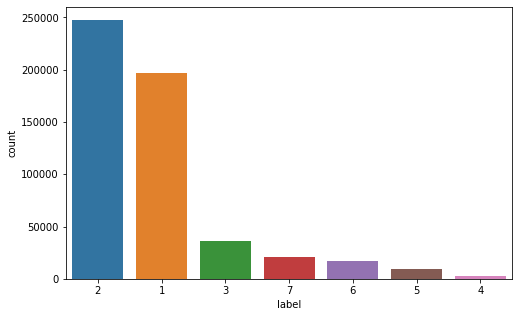

In [35]:
# Target variable visualisation:
print(len(data_withoutoutliers_pd))
plt.figure(figsize=(8,5))
sns.countplot(x='label', data=data_withoutoutliers_pd, order=data_withoutoutliers_pd['label'].value_counts().index)

# Data visualisation 

Dealing numerical data: We have 11 numerical features such as Elevation, Aspect, Slope, Horizontal_Distance_To_Hydrology, Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,
Hillshade_9am, Hillshade_Noon, Hillshade_3pm,Horizontal_Distance_To_Fire_Points, label with respect to data set.

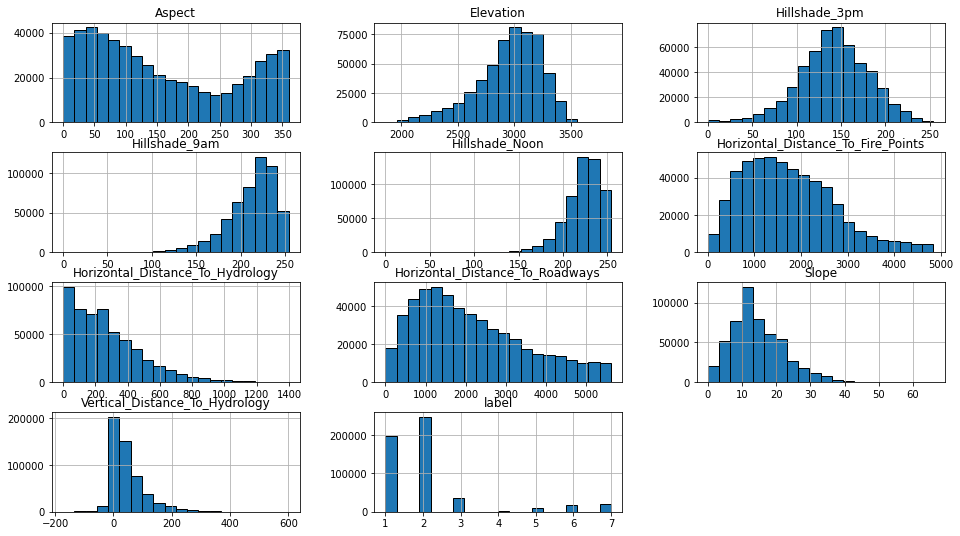

In [36]:
# Data visualisation of numerical variables :
numerical_data = data_withoutoutliers_pd[['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'label']]
numerical_data.hist(figsize=(16,9), edgecolor="black", bins=20)
plt.show()

Dealing with categorical data: We have 44 categorical features which includes wilderness area (1 to 4 ) and soil type (1-40)

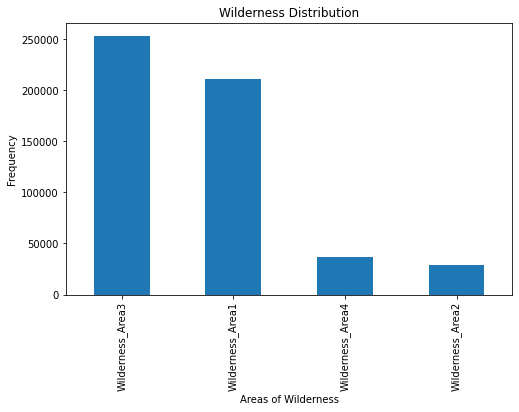

In [37]:
# Data visualisation of categorical data - wilderness area :
wilderness_columns = data_withoutoutliers_pd[['Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4']]
Types_of_Wilderness = []
for index, row in data_withoutoutliers_pd.iterrows():
    x = 'NA_Wildernesstypes_values'
    for col in wilderness_columns:
        if row[col] == 1:
            x = col
            break
    Types_of_Wilderness.append(x)
data_withoutoutliers_pd['Wilderness_Areas'] = Types_of_Wilderness

# print(pd.value_counts(df['Wilderness_Areas']))
figure1 = data_withoutoutliers_pd['Wilderness_Areas'].value_counts().plot(kind='bar',
                                    figsize=(8,5),
                                    title="Wilderness Distribution")
figure1.set_xlabel("Areas of Wilderness")
figure1.set_ylabel("Frequency")
plt.show()

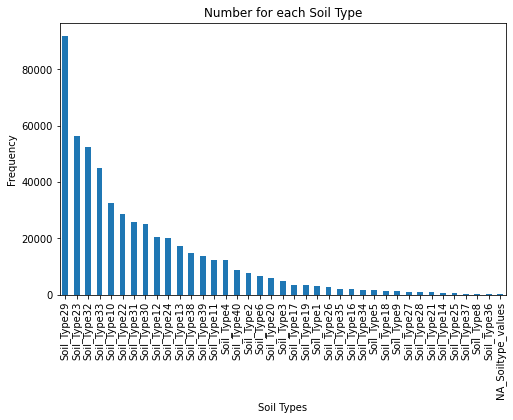

In [38]:
# Plotting soil_type categorical data of trainset 
soil_columns = data_withoutoutliers_pd[['Soil_Type1', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type8',
       'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40']]
Types_of_soil = []
for index, row in data_withoutoutliers_pd.iterrows():
    x = 'NA_Soiltype_values'
    for col in soil_columns:
        if row[col] == 1:
            x = col
            break
    Types_of_soil.append(x)
data_withoutoutliers_pd['Soil_kinds'] = Types_of_soil

# print(pd.value_counts(df['Soil_Types']))
figure2 = data_withoutoutliers_pd['Soil_kinds'].value_counts().plot(kind='bar',
                                    figsize=(8,5),
                                    title="Number for each Soil Type")
figure2.set_xlabel("Soil Types")
figure2.set_ylabel("Frequency")
plt.show()

# Statistical analysis :

In [41]:
# Checking null value in data set :
### Get count of null values in pyspark :

from pyspark.sql.functions import isnan, when, count, col
total_null_count = data_withoutoutliers.select([count(when(col(c).isNull(), c)).alias(c) for c in data_withoutoutliers.columns])
total_null_count.show()

+---------+------+-----+--------------------------------+------------------------------+-------------------------------+-------------+--------------+-------------+----------------------------------+----------------+----------------+----------------+----------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----+
|Elevation|Aspect|Slope|Horizontal_Distance_To_Hydrology|Vertical_Distance_To_Hydrology|Horizontal_Distance_To_Roadways|Hillshade_9am|Hillshade_Noon|Hillshade_3pm|Horizontal_Distance_To_Fire_Points|Wilderness_Area1|Wilderness_Area2|Wilderness_Area3|Wildern

In [42]:
# Getting the mean and standard deviation of target variable :
data_withoutoutliers.select(mean("label"),stddev("label")).show()

+------------------+------------------+
|        avg(label)|stddev_samp(label)|
+------------------+------------------+
|2.0838669715848255|1.4496121905962502|
+------------------+------------------+



In [43]:
# Final shape of the data after outlier removal :
print((data_withoutoutliers.count(), len(data_withoutoutliers.columns)))

(529541, 55)


# Correlation

Correlation is a statistical technique that can show whether and how strongly pairs of variables are related. Vector assembler is used in pyspark.Its job is to combine the raw features and features generated from various transforms into a single feature vector for model splitting and prediction. It accepts boolean, numerical and vector type inputs.
Here all 55 features are considered to perfrom correlation .

In [44]:
# Considering features for correlation:
corr_columns = ('Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
                            'Horizontal_Distance_To_Roadways', 'Hillshade_9am','Hillshade_Noon', 'Hillshade_3pm','Horizontal_Distance_To_Fire_Points',
                             'Wilderness_Area1','Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
                              'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
                              'Soil_Type6', 'Soil_Type7','Soil_Type8','Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
                              'Soil_Type13', 'Soil_Type14','Soil_Type15', 'Soil_Type16', 'Soil_Type17',
                              'Soil_Type18', 'Soil_Type19', 'Soil_Type20', 'Soil_Type21',
                              'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type25',
                              'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29',
                              'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33',
                              'Soil_Type34', 'Soil_Type35', 'Soil_Type36', 'Soil_Type37',
                              'Soil_Type38', 'Soil_Type39', 'Soil_Type40','label')
corr_feature = VectorAssembler(inputCols=corr_columns,outputCol="corr_vector")
corr_feature_vector= corr_feature.transform(data_withoutoutliers).select("corr_vector")

In [45]:
# Getting correlation matrix:
corr_vector_col = "corr_vector"
final_matrix = Correlation.corr(corr_feature_vector, corr_vector_col).collect()[0][0]
corr_matrix = final_matrix.toArray().tolist()
print(corr_matrix)

[[1.0, 0.011905055485133462, -0.24834627932084166, 0.3071033383279562, 0.09104841319110304, 0.3833042584844533, 0.11768152569063163, 0.2035916227839356, 0.05397122729823003, 0.26370779950701967, 0.13700337887665234, 0.24024651564759705, 0.07887774002053453, -0.6304169420140442, -0.20764805117337573, -0.1901851232484283, -0.18504235365669744, -0.1857245276805237, -0.152670789447052, -0.2176779396124336, -0.0016787055165534924, -0.002390813224830429, -0.06162887150207247, -0.43562431813547453, -0.13547268635736612, -0.11571388983447153, -0.04323861870767661, -0.08201546672726434, -0.007263288355761269, -0.05581695127790976, -0.11238800367842039, -0.06664115677765539, 0.030702050335544274, -0.05223897950240082, 0.01823004740647592, 0.14196439847006875, 0.12664997037689615, 0.05660026963552477, 0.02954350073194697, -0.01635102781790472, 0.03630180468606551, -0.029438102105234343, 0.07558441401508381, -0.029023836133898036, 0.07383793713904767, 0.17387982931011386, 0.07490382274931895, 0.01

In [46]:
# Converting correlation matrix to dataframe:
corr_df = spark.createDataFrame(corr_matrix,corr_columns)
corr_df.show()

+--------------------+--------------------+--------------------+--------------------------------+------------------------------+-------------------------------+--------------------+--------------------+--------------------+----------------------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------

In [47]:
# For plotting the correlation heatmap , we are converting the pyspark dataframe to pandas dataframe :
corr_df_pd = corr_df.toPandas()
corr_val = corr_df_pd.corr()
corr_val.sort_values(["label"])
corr_val.label.sort_values(ascending=False)


label                                 1.000000
Wilderness_Area4                      0.629873
Soil_Type10                           0.567067
Slope                                 0.417947
Soil_Type6                            0.321052
Soil_Type1                            0.275389
Soil_Type2                            0.267973
Soil_Type4                            0.235740
Soil_Type5                            0.222353
Soil_Type3                            0.217965
Vertical_Distance_To_Hydrology        0.182117
Soil_Type39                           0.181589
Soil_Type17                           0.178736
Soil_Type38                           0.158646
Soil_Type14                           0.135858
Soil_Type40                           0.119703
Soil_Type11                           0.108883
Wilderness_Area3                      0.104056
Soil_Type37                           0.095961
Soil_Type13                           0.085719
Soil_Type35                           0.080185
Aspect       

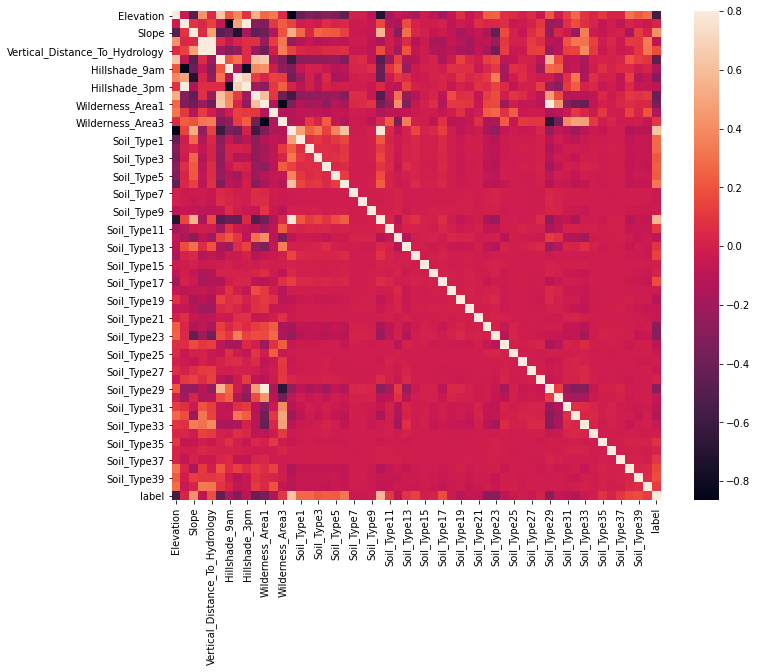

In [48]:
# Heatmap correlation :
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr_val , vmax=.8, square=True);

# Train test split 

Vector assembler is used in pyspark.Its job is to combine the raw features and features generated from various transforms into a single feature vector for model splitting and prediction. It accepts boolean, numerical and vector type inputs.

In [11]:
# Performing vector assembler : all features are considered except target variable "label"
feature_columns = ('Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
                            'Horizontal_Distance_To_Roadways', 'Hillshade_9am','Hillshade_Noon', 'Hillshade_3pm','Horizontal_Distance_To_Fire_Points',
                             'Wilderness_Area1','Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
                              'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
                              'Soil_Type6', 'Soil_Type7','Soil_Type8','Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
                              'Soil_Type13', 'Soil_Type14','Soil_Type15', 'Soil_Type16', 'Soil_Type17',
                              'Soil_Type18', 'Soil_Type19', 'Soil_Type20', 'Soil_Type21',
                              'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type25',
                              'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29',
                              'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33',
                              'Soil_Type34', 'Soil_Type35', 'Soil_Type36', 'Soil_Type37',
                              'Soil_Type38', 'Soil_Type39', 'Soil_Type40')
feature = VectorAssembler(inputCols=feature_columns,outputCol="features")
feature_vector= feature.transform(data_withoutoutliers)

splitting 60% train set and 40 % test set for model prediction 

In [12]:
(train_data, test_data) = feature_vector.randomSplit([0.6, 0.4],seed = 100)

In [51]:
print("Train data size: {:d} instances".format(train_data.count()))
print("Test data size: {:d} instances".format(test_data.count()))

Train data size: 317841 instances
Test data size: 211700 instances


# Machine learning models

Forest cover type prediction is a multi-class classification dataset. Here 7 types of cover_type is predicted. Our dataset has both positive and negative values. 



Logistics regression: Logistic regression is the appropriate regression analysis to conduct when the dependent variable is binary. Logistic regression is used to describe data and to explain the relationship between one dependent binary variable and one or more nominal, ordinal, interval or ratio-level independent variables. It is used in classification analysis.

Decision Tree: The decision criteria are different for classification and regression trees. Decision trees use multiple algorithms to decide to split a node into two or more sub-nodes.The decision tree splits the nodes on all available variables and then selects the split which results in most homogeneous sub-nodes.

Random Forest: Random forests or random decision forests are an ensemble learning method for classification, regression and other tasks that operate by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes or mean prediction of the individual trees.

Multiclass Classification: It is a type of modeling wherein the output is discrete.These models have a specialized set of charts and metrics for their evaluation such as accuracy, precision, f1-score, recall.

Accuracy in Machine Learning
is the number of correctly predicted data points out of all the data points. More formally, it is defined as the number of true positives and true negatives divided by the number of true positives, true negatives, false positives, and false negatives.

Precision-Recall is a useful measure of success of prediction when the classes are very imbalanced. In information retrieval, precision is a measure of result relevancy, while recall is a measure of how many truly relevant results are returned.Precision is defined as the number of true positives divided by the number of true positives plus the number of false positives.The precise definition of recall is the number of true positives divided by the number of true positives plus the number of false negatives.

F1 score (also F-score or F-measure) is a measure of a test's accuracy.t considers both the precision p and the recall r of the test to compute the score.

A true positive is an outcome where the model correctly predicts the positive class. Similarly, a true negative is an outcome where the model correctly predicts the negative class. A false positive is an outcome where the model incorrectly predicts the positive class. And a false negative is an outcome where the model incorrectly predicts the negative class.

A confusion matrix is a table that is often used to describe the performance of a classification model (or “classifier”) on a set of test data for which the true values are known. It allows the visualization of the performance of an algorithm.

# Logistics regression 

In [32]:
logreg = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=20)
logreg_model = logreg.fit(train_data)
logreg_predictions = logreg_model.transform(test_data)

coefficients and intercepts:

In [53]:
print("Coefficients: " + str(logreg_model.coefficientMatrix))
print("Intercept: " + str(logreg_model.interceptVector))

Coefficients: DenseMatrix([[-1.22945454e-06, -4.35601242e-07, -9.43163634e-06,
              -2.04313302e-07, -4.91032744e-07, -3.61761838e-08,
              -9.92024201e-06, -1.92280281e-05, -3.25527271e-06,
              -5.82468238e-08, -4.49958540e-05, -3.07662500e-05,
              -7.91647401e-05, -4.45721068e-05, -2.93599958e-05,
              -5.80605635e-05, -5.64395197e-05, -5.82011994e-05,
              -3.19070676e-05, -4.52771864e-05, -1.71963702e-05,
              -2.14492831e-05, -2.24409753e-05, -5.98233358e-05,
              -3.91884625e-05, -2.00716578e-05, -3.85596670e-05,
              -5.70158011e-05, -2.47254178e-05, -4.32514466e-05,
              -7.86200627e-05, -1.87611952e-05, -2.78368084e-05,
              -3.54536530e-05, -2.35600619e-05, -2.71585692e-05,
              -3.39879674e-05, -3.73218925e-05, -2.96823556e-05,
              -2.60730021e-05, -4.07081362e-05, -2.54345780e-05,
              -3.34687951e-05, -3.43112055e-05, -3.86300413e-05,
           

In [55]:
logreg_col = logreg_predictions.select("label", "prediction", "probability")
logreg_col.show()

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|    6|       3.0|[1.71800551040493...|
|    6|       3.0|[4.75610247358040...|
|    3|       3.0|[1.81349542990363...|
|    3|       3.0|[1.77196928244528...|
|    6|       3.0|[5.39285483860088...|
|    6|       3.0|[5.16372867334985...|
|    6|       3.0|[1.65655350964762...|
|    6|       3.0|[6.50821955560934...|
|    3|       3.0|[1.74995887815075...|
|    6|       3.0|[5.05277957757542...|
|    6|       3.0|[6.67213142084960...|
|    3|       3.0|[1.80733764916097...|
|    6|       3.0|[6.43490840214707...|
|    6|       3.0|[5.03872134353839...|
|    6|       3.0|[4.78137208222860...|
|    6|       3.0|[5.07722022788283...|
|    6|       3.0|[1.63363061979509...|
|    6|       3.0|[4.04697815489200...|
|    6|       3.0|[1.64594594130329...|
|    6|       3.0|[4.91903116046195...|
+-----+----------+--------------------+
only showing top 20 rows



In [56]:
logreg_evaluator = MulticlassClassificationEvaluator()

accuracy = logreg_evaluator.evaluate(logreg_predictions, {logreg_evaluator.metricName: 'accuracy'})
precision = logreg_evaluator.evaluate(logreg_predictions,{logreg_evaluator.metricName: 'weightedPrecision'})
f1_score = logreg_evaluator.evaluate(logreg_predictions, {logreg_evaluator.metricName: 'f1'})
recall =  logreg_evaluator.evaluate(logreg_predictions, {logreg_evaluator.metricName: 'weightedRecall'})
print('Logistics regression accuracy : ',accuracy)
print('Logistics regression precision : ',precision)
print('Logistics regression f1-Score : ',f1_score)
print('Logistics regression recall : ',recall)
print("Logistics regression_test Error : %g " % (1.0 - accuracy))

Logistics regression accuracy :  0.6792158715162967
Logistics regression precision :  0.6620410653869715
Logistics regression f1-Score :  0.6657061653210629
Logistics regression recall :  0.6792158715162966
Logistics regression_test Error : 0.320784 


In [33]:
# logistics regression confusion matrix 
y_prediction = logreg_predictions.select('prediction')
y_prediction_lr = y_prediction.toPandas()

y_true = logreg_predictions.select('label')
y_true_lr = y_true.toPandas()

logreg_CM = confusion_matrix(y_true_lr, y_prediction_lr,labels=range(5))

print(logreg_CM)

[[    0     0     0     0     0]
 [    0 51860 23598    75     0]
 [    0 21090 74570  2493     0]
 [    0     0  1543 11952     0]
 [    0     0     0   771     0]]


# Decision tree classifier

In [34]:
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label')
dt_model = dt.fit(train_data)
dt_predictions = dt_model.transform(test_data)
dt_col = dt_predictions.select("label", "prediction", "probability")
dt_col.show(10)

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|    6|       3.0|[0.0,0.0,0.030067...|
|    6|       3.0|[0.0,0.0,0.030067...|
|    3|       3.0|[0.0,0.0,0.030067...|
|    3|       3.0|[0.0,0.0,0.030067...|
|    6|       4.0|[0.0,0.0,0.038280...|
|    6|       3.0|[0.0,0.0,0.030067...|
|    6|       3.0|[0.0,0.0,0.030067...|
|    6|       3.0|[0.0,0.0,0.030067...|
|    3|       3.0|[0.0,0.0,0.030067...|
|    6|       3.0|[0.0,0.0,0.030067...|
+-----+----------+--------------------+
only showing top 10 rows



In [59]:
dt_evaluator = MulticlassClassificationEvaluator()

accuracy = dt_evaluator.evaluate(dt_predictions, {dt_evaluator.metricName: 'accuracy'})
precision = dt_evaluator.evaluate(dt_predictions,{dt_evaluator.metricName: 'weightedPrecision'})
f1_score = dt_evaluator.evaluate(dt_predictions, {dt_evaluator.metricName: 'f1'})
recall =  dt_evaluator.evaluate(dt_predictions, {dt_evaluator.metricName: 'weightedRecall'})
print('Decision tree accuracy : ',accuracy)
print('Decision tree precision : ',precision)
print('Decision tree f1-Score : ',f1_score)
print('Decision tree recall : ',recall)
print("Decision tree_test Error : %g " % (1.0 - accuracy))

Decision tree accuracy :  0.7015351913084553
Decision tree precision :  0.6947499080912228
Decision tree f1-Score :  0.685652211287148
Decision tree recall :  0.7015351913084554
Decision tree_test Error : 0.298465 


In [35]:
# Decision tree confusion matrix 
y_prediction = dt_predictions.select('prediction')
y_prediction_dt = y_prediction.toPandas()

y_true = dt_predictions.select('label')
y_true_dt = y_true.toPandas()

dt_CM = confusion_matrix(y_true_dt, y_prediction_dt,labels=range(5))

print(dt_CM)

[[    0     0     0     0     0]
 [    0 59096 16943    99     0]
 [    0 24881 70698  3249    40]
 [    0     0  1098 12760   295]
 [    0     0     0   651   415]]


# Random forest classifier 

In [36]:
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=20)
rf_model = rf.fit(train_data)
rf_predictions = rf_model.transform(test_data)
rf_col = rf_predictions.select("label", "prediction", "probability")
rf_col.show(10)

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|    6|       3.0|[0.0,0.0586643846...|
|    6|       3.0|[0.0,0.0617813213...|
|    3|       3.0|[0.0,0.0586643846...|
|    3|       3.0|[0.0,0.0586643846...|
|    6|       3.0|[0.0,0.0617813213...|
|    6|       3.0|[0.0,0.0617813213...|
|    6|       3.0|[0.0,0.0586643846...|
|    6|       3.0|[0.0,0.0528514320...|
|    3|       3.0|[0.0,0.0586643846...|
|    6|       3.0|[0.0,0.0617813213...|
+-----+----------+--------------------+
only showing top 10 rows



In [18]:
import requests
rf_evaluator = MulticlassClassificationEvaluator()

accuracy = rf_evaluator.evaluate(rf_predictions, {rf_evaluator.metricName: 'accuracy'})
precision = rf_evaluator.evaluate(rf_predictions,{rf_evaluator.metricName: 'weightedPrecision'})
f1_score = rf_evaluator.evaluate(rf_predictions, {rf_evaluator.metricName: 'f1'})
recall =  rf_evaluator.evaluate(rf_predictions, {rf_evaluator.metricName: 'weightedRecall'})
print('Random forest accuracy : ',accuracy)
print('Random forest precision : ',precision)
print('Random forest f1-Score : ',f1_score)
print('Random forest recall : ',recall)
print("Random forest_test Error : %g " % (1.0 - accuracy))

Random forest accuracy :  0.6716674539442608
Random forest precision :  0.6085124296798045
Random forest f1-Score :  0.6385006163904332
Random forest recall :  0.6716674539442608
Random forest_test Error : 0.328333 


In [37]:
# Random forest confusion matrix 
y_prediction = rf_predictions.select('prediction')
y_prediction_rf = y_prediction.toPandas()

y_true = rf_predictions.select('label')
y_true_rf = y_true.toPandas()

dt_CM = confusion_matrix(y_true_rf, y_prediction_rf,labels=range(5))

print(dt_CM)

[[    0     0     0     0     0]
 [    0 57059 21355     0     0]
 [    0 23317 74649  1209     0]
 [    0     0  5658  8495     0]
 [    0     0     0  1066     0]]


# Hypertuning parameters

In machine learning, hyperparameter optimization or tuning is the problem of choosing a set of optimal hyperparameters for a learning algorithm. A hyperparameter is a parameter whose value is used to control the learning process. A hyperparameter is a parameter whose value is set before the learning process begins. Grid Search tuning strategy - A traditional way to perform hyperparameter optimization. It works by searching exhaustively through a specified subset of hyperparameters. Random Search tuning strategy - Random search differs from grid search mainly in that it searches the specified subset of hyperparameters randomly instead of exhaustively. The major benefit being decreased processing time. There is a tradeoff to decreased processing time, however. We aren’t guaranteed to find the optimal combination of hyperparameters. 

Cross validation : It is used to assess the predictive performance of the models and and to judge how they perform outside the sample to a new data set also known as test data. The motivation to use cross validation techniques is that when we fit a model, we are fitting it to a training dataset.

Steps in cross validation :

1.Estimator: algorithm or Pipeline to tune. \
2.Set of ParamMaps: parameters to choose from, sometimes called a “parameter grid” to search over. \
3.Evaluator: metric to measure how well a fitted Model does on held-out test data.

Logistics regression :

In [13]:
# Logistics regression :
logreg_hp = LogisticRegression(featuresCol = 'features', labelCol = 'label')

#tuning parameters:
param_grid = ParamGridBuilder()\
    .addGrid(logreg_hp.regParam, [0.0, 0.3, 0.7]) \
    .addGrid(logreg_hp.elasticNetParam, [0.3, 0.4, 0.5]) \
    .build()

evaluator_logreg= MulticlassClassificationEvaluator(metricName="accuracy")

#applying 3 folds cross validation
cross_val = CrossValidator(estimator=logreg_hp, 
                               estimatorParamMaps=param_grid,
                               evaluator = evaluator_logreg,
                               numFolds=3
                               )



In [14]:
# Fitting and prediction
cvModel = cross_val.fit(train_data)
predictions_logreg = cvModel.transform(test_data)

In [15]:
final_evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
log_hp = final_evaluator.evaluate(predictions_logreg)

In [17]:
print("Logistics regression accuracy after hyperparameter tuning : " ,log_hp)

Logistics regression accuracy after hyperparameter tuning :  0.706126594237128


Decision tree

In [24]:
# decision tree
decisiontree = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label')

#tuning paramters
param_grid = ParamGridBuilder()\
    .addGrid(decisiontree.maxDepth, [2,5,10]) \
    .addGrid(decisiontree.maxBins, [10,20,30]) \
    .addGrid(decisiontree.impurity,["gini"])\
    .build()


decisiontree_evaluator= MulticlassClassificationEvaluator(metricName="accuracy")

# applying 3 folds cross validation
cv_dt = CrossValidator(estimator=decisiontree, 
                               estimatorParamMaps=param_grid,
                               evaluator = decisiontree_evaluator,
                               numFolds=3
                              )

In [25]:
# Fitting and prediction
cvModel_dt = cv_dt.fit(train_data)
predictions_dt = cvModel_dt.transform(test_data)

In [26]:
final_evaluator_ = MulticlassClassificationEvaluator(metricName="accuracy")
dt_hp = final_evaluator_.evaluate(predictions_dt)

In [27]:
print("Decision tree accuracy after hyperparameter tuning : " ,dt_hp)

Decision tree accuracy after hyperparameter tuning :  0.7800850259801606


Random Forest :

In [18]:
# Random forest:
Randomforest = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')

# tuning paramteres:
param_grid = ParamGridBuilder() \
    .addGrid(Randomforest.maxDepth,[2,5,10]) \
    .addGrid(Randomforest.numTrees,[20,40,80]) \
    .build()

randomforest_evaluator= MulticlassClassificationEvaluator(metricName="accuracy")

# applying 3 folds cross validation
cv_rf = CrossValidator(estimator=Randomforest, 
                               estimatorParamMaps=param_grid,
                               evaluator = randomforest_evaluator,
                               numFolds=3
                               )

In [19]:
# Fitting and prediction
cvModel_rf = cv_rf.fit(train_data)
predictions_rf = cvModel_rf.transform(test_data)

In [21]:
final_evaluator_rf = MulticlassClassificationEvaluator(metricName="accuracy")
rf_hp = final_evaluator_rf.evaluate(predictions_rf)

In [22]:
print("Random forest accuracy after hyperparameter tuning : " ,rf_hp)

Random forest accuracy after hyperparameter tuning :  0.7302456306093529


# Prediction analysis

Getting the true and predicted value after hyper tuning parameters of three models

In [28]:
# Logistics regression
y_prediction = predictions_logreg.select('prediction')
y_prediction_log_hp = y_prediction.toPandas()
y_true = predictions_logreg.select('label')
y_true_log_hp = y_true.toPandas()

# Decision tree
y_prediction = predictions_dt.select('prediction')
y_prediction_dt_hp = y_prediction.toPandas()
y_true = predictions_dt.select('label')
y_true_dt_hp = y_true.toPandas()

# Random forest
y_prediction = predictions_rf.select('prediction')
y_prediction_rf_hp = y_prediction.toPandas()
y_true = predictions_rf.select('label')
y_true_rf_hp = y_true.toPandas()

ROC-AUC score \
An ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds. This curve plots two parameters:

1.True Positive Rate = TP/(TP+FN)
2.False Positive Rate = FP/(FP+TN)

Computed Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores.

ROC - AUC score ranges from low 0.5 to high 1.0


 


In [29]:
# Roc curve function: Since it is a multiclass classification dataset, pyspark doesnt have library to calculate roc curve. Hence Sklearn is used here.
def multiclass_classification_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)


In [38]:
# Printing Roc value of the models before hyper tuning:
print('logistics regression ROC AUC score:', multiclass_classification_roc_auc_score(y_true_lr,y_prediction_lr))
print('Decision tree ROC AUC score:', multiclass_classification_roc_auc_score(y_true_dt,y_prediction_dt))
print('Random forest ROC AUC score:', multiclass_classification_roc_auc_score(y_true_rf,y_prediction_rf))


logistics regression ROC AUC score: 0.6737376403476303
Decision tree ROC AUC score: 0.7019721119721758
Random forest ROC AUC score: 0.608035307071314


In [39]:
# Printing Roc value of the model after hypertuning:
print('Hyper_tuned logistics regression  ROC AUC score:', multiclass_classification_roc_auc_score(y_true_log_hp,y_prediction_log_hp))
print('Hyper_tuned Decision tree ROC AUC score:', multiclass_classification_roc_auc_score(y_true_dt_hp,y_prediction_dt_hp))
print('Hyper_tuned Random forest ROC AUC score:', multiclass_classification_roc_auc_score(y_true_rf_hp,y_prediction_rf_hp))


Hyper_tuned logistics regression  ROC AUC score: 0.69765274378896
Hyper_tuned Decision tree ROC AUC score: 0.765949719404438
Hyper_tuned Random forest ROC AUC score: 0.7032132838182857


In [40]:
# Decision tree has more accuracy , hence looking at its table 
df_hp_col = predictions_dt.select("label", "prediction", "probability")
df_hp_col.show(10)

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|    6|       3.0|[0.0,0.0,0.046246...|
|    6|       3.0|[0.0,0.0,0.026742...|
|    3|       3.0|[0.0,0.0,0.046246...|
|    3|       3.0|[0.0,0.0,0.046246...|
|    6|       4.0|[0.0,0.0,0.05,0.2...|
|    6|       3.0|[0.0,0.0,0.046246...|
|    6|       3.0|[0.0,0.0,0.046246...|
|    6|       3.0|[0.0,0.0,0.046246...|
|    3|       3.0|[0.0,0.0,0.046246...|
|    6|       3.0|[0.0,0.0,0.046246...|
+-----+----------+--------------------+
only showing top 10 rows



In [41]:
# Converting decision tree df to pandas to get the size of the label.
df_hp_pd = df_hp_col.toPandas()
df_hp_pd['label'].size

211700

In [42]:
df_hp_pd.columns

Index(['label', 'prediction', 'probability'], dtype='object')

In [43]:
results = df_hp_pd.groupby('label').size()

In [44]:
results #the total number of growth accroding to label.

label
1    78414
2    99175
3    14153
4     1066
5     3660
6     7000
7     8232
dtype: int64

# Conclusion

Thus Decision tree classifier produces accuracy of 0.78 .

Most cover_type : Label 2 (Lodgepole Pine tree) \
Least cover _type : Label 4 (Cottonwood/Willow tree)


Hence the growth of Lodgepole pine tree is more , as per decision tree classifier prediction .




